<a href="https://colab.research.google.com/github/haru1489248/PyTorch-Tutorials/blob/main/0_2_data_tutorial_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

「PyTorch入門  2. データセットとデータローダー」
===============================================================
【原題】DATASETS & DATALOADERS

【原著】
[Suraj Subramanian](https://github.com/suraj813)、[Seth Juarez](https://github.com/sethjuarez/) 、[Cassie Breviu](https://github.com/cassieview/) 、[Dmitry Soshnikov](https://soshnikov.com/)、[Ari Bornstein](https://github.com/aribornstein/)


【元URL】https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　小川 雄太郎

【日付】2021年03月20日

【チュトーリアル概要】

本チュートリアルでは、PyTorchでサンプルデータを扱う基本要素である、DatasetとDataLoaderについて解説を行います。

---



Datasets & Dataloaders
===================

サンプルデータを処理するコードは複雑であり、メンテナンスも大変です。

データセットに関するコードは可読性とモジュール性を考慮し、モデルの訓練コードから切り離すのが理想的です。




PyTorchにはデータセットを扱う基本要素が2つあります。

``torch.utils.data.DataLoader``と、``torch.utils.data.Dataset``です。

これらを活用することであらかじめ用意されたデータセットや自分で作成したデータを使用することができます。



``Dataset``にはサンプルとそれに対応するラベルが格納され、``DataLoader``にはイテレート処理が可能なデータが格納されます。

``DataLoader``は、サンプルを簡単に利用できるように、``Dataset``をイテレート処理可能なものへとラップします。

PyTorch domain librariesでは、多くのデータセット（FashionMNISTなど）を提供しています。

これらは ``torch.utils.data.Dataset`` を継承しており、各ドメインのデータに対して必要な、固有の機能を実装しています。

また、皆様が実装したモデルのベンチマークにも使うことができます。

さらなる詳細は以下をご覧ください。




- [Image Datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)  

- [Text Datasets](https://pytorch.org/text/stable/datasets.html)

- [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

---



Datasetの読み込み
-------------------

TorchVisionから[Fashion-MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)をロードする例を紹介します。

Fashion-MNISTは、60,000個の訓練データと10,000個のテストデータから構成された、Zalandoの記事画像のデータセットです。

各サンプルは、28×28のグレースケール画像と、10クラスのうちの1つのラベルから構成されています。




[FashionMNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)を読み込む際には、以下のパラメータを使用します。


- ``root`` ：訓練/テストデータが格納されているパスを指定
- ``train`` ：訓練データまたはテストデータセットを指定
- ``download=True``：``root`` にデータが存在しない場合は、インターネットからデータをダウンロードを指定
- ``transform`` と ``target_transform``：特徴量とラベルの変換を指定

## 学習したこと
- root: データをどこに置くかを指定する
- train: 学習データか検証データか指定する
- transform: データ型を変換したりデータの前処理用の関数を渡したりする（入力用）
- target_transform: transformと同じだが正解用の関数を渡す

In [ ]:
%matplotlib inline

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

---



データセットの反復処理と可視化
-----------------

Datasetの特定indexを指定する際には、リスト操作と同様に、``training_data[index]``と記載します。

``matplotlib``を使用し、訓練データのいくつかのサンプルを可視化しましょう。

## 学習したこと
- torch.randint(): 与えられた条件の中でランダムに整数を作成する
  - 第一引数: 整数の上限
  - size: tensorデータのサイズ

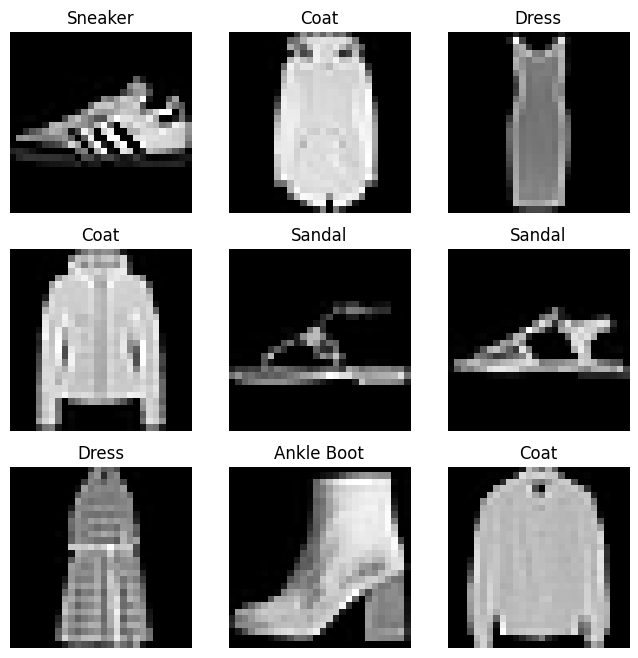

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # labelはlabels_mapのkeyが渡ってくる
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    # メモリなどを非表示にする（グラフではないので非表示にしている）
    plt.axis("off")
    # imgのshapeが[1, 28, 28]の様な三次元のデータになっているので、1の軸をsqueeze()で消して、2次元の画像にしている
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

--------------




カスタムデータセットの作成
---------------------------------------------------

自分でカスタムしたDatasetクラスを作る際には、 `__init__`、`__len__`、`__getitem__`の3つの関数は必ず実装する必要があります。

これらの関数の実装を確認します。

FashionMNISTの画像データを``img_dir``フォルダに、ラベルはCSVファイル``annotations_file``として保存します。

これから、各関数がどのような操作を行っているのか詳細に確認します。



In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
      # 0番目の列にはファイル名が入っているそう、下に書いてあった
      # img_labelsのidx行, 0列目を取得している
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # iloc = integer location
        image = read_image(img_path)
        # 1列目には0列目に対応したlabelが入っている
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

**__init__**


`__init__`関数はDatasetオブジェクトがインスタンス化される際に1度だけ実行されます。

画像、アノテーションファイル、そしてそれらに対する変換処理（transforms：次のセクションで解説します）の初期設定を行います。

<br>

ここで、labels.csvファイルは以下のような内容となっています。

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

**__len__**


`__len__`関数はデータセットのサンプル数を返す関数です。



In [ ]:
def __len__(self):
    return len(self.img_labels)

**__getitem__**

`__getitem__`関数は指定された``idx``に対応するサンプルをデータセットから読み込んで返す関数です。

`index`に基づいて、画像ファイルのパスを特定し、``read_image``を使用して画像ファイルをテンソルに変換します。

加えて、``self.img_labels``から対応するラベルを抜き出します。

そしてtransform functionsを必要に応じて画像およびラベルに適用し、最終的にPythonの辞書型変数で画像とラベルを返します。



In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

--------------




DataLoaderの使用方法
-------------------------------------------------

``Dataset``を使用することで1つのサンプルの、データとラベルを取り出せます。

ですが、モデルの訓練時にはミニバッチ（"minibatches"）単位でデータを扱いたく、また各epochでデータはシャッフルされて欲しいです（訓練データへの過学習を防ぐ目的です）。

加えて、Pythonの ``multiprocessing``を使用し、複数データの取り出しを高速化したいところです。

``DataLoader``は上記に示した複雑な処理を簡単に実行できるようにしてくれるAPIとなります。


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

DataLoaderを用いた繰り返し処理
--------------------------

データセットを ``Dataloader`` に読み込ませ、必要に応じてデータセットを反復処理することができます。

以下の各反復処理では``train_features`` と ``train_labels``のミニバッチを返します（それぞれ、64個のサンプルで構成されるミニバッチです）。

今回``shuffle=True``と指定しているので、データセットのデータを全て取り出したら、データの順番はシャッフルされます。

<br>

さらなるデータ読み込み操作の詳細については、[こちらのSamplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)をご覧ください。


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


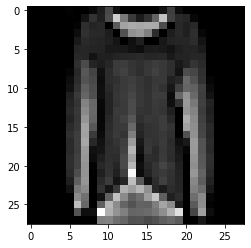

Label: 2


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

--------------




さらなる詳細
--------------
以下のページも参考ください。

- [torch.utils.data API](https://pytorch.org/docs/stable/data.html)



以上。